In [18]:
import numpy as np # Linear algebra

# Data processing, CSV file I/O (e.g. pd.read_csv)
import pandas as pd
from pandas import DataFrame
import csv

import xml.etree.ElementTree as ET # Reading xml files

# For plotting
import matplotlib.pyplot as plt
import pydot
import pydotplus
import graphviz
from keras.utils.vis_utils import plot_model
from keras.utils import *
from sklearn.manifold import TSNE


# For Modelling
import tensorflow as tf
from tensorflow.keras import layers, models, preprocessing, callbacks, optimizers

# print(tf.VERSION)
# print(tf.keras.__version__)

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Embedding, Input, Add
from tensorflow.keras.layers import LSTM, Bidirectional, GlobalMaxPool1D, Dropout
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import concatenate
from keras.metrics import categorical_accuracy


# For Pre-processing
import string
from string import digits
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm
import re

# Other useful modules
import h5py
from statistics import mode
import os
import datetime
import warnings
warnings.filterwarnings('ignore')
                    

In [2]:
                        
def csv_row(xml_file):

    tree = ET.parse(xml_file)
    root = tree.getroot()
    
    nct_text = ""
    sum_text = ""
    model_text = ""
    ph_text = ""
    title_text = ""
    year_text = ""
    condition_disease_text= ""
    description_text = ""
    failed_text_full=""
    
    if root.iter('drop_withdraw_reason'):
        # Only iterates through Phase 2 and 3 studies
        for ph in root.iter('phase'):
            ph_text = ph.text
        if (ph_text == "Phase 2" or ph_text == "Phase 3"):
            for date in root.iter('start_date'):
                    year_text = date.text
            if '2016' or '2017' or '2018' or '2019' or '2020' in year_text:

                #This bit finds all roots with nct_id which is a sub_root to id_info
                for nct in root.findall('id_info'):
                    nctId_text = nct.find('nct_id').text
                    nct_text =nctId_text
                    #print(nct_text)

                # This bit finds the brief summary text
                for s in root.findall('brief_summary'):
                    summary_text = s.find('textblock').text
                    sum_text= summary_text
                    sum_text = sum_text.replace('\n', '') # Replaces newline with a whitespace
                    sum_text = re.sub(' +',' ',sum_text) # Compresses multiple whitespaces to only one
                    #print("Summary Text:", sum_text)

                # Get's the official title for the study
                for t in root.iter('brief_title'):
                    title_text = t.text

                # This get's the type of intervention_model
                for y in root.iter('intervention_model'):
                    model_text = y.text

                for date in root.iter('start_date'):
                    year_text = date.text
                    #print(year_text)

                for condition in root.iter('condition'):
                    condition_disease_text = condition.text
                    #print(condition_disease_text)


                for reason in root.iter('drop_withdraw_reason'):
                    failed_text_full= failed_text_full+', ' +f'{reason[0].text}'
                #print("withdraw reason", failed_text_full)


    total_text = "\"" + nct_text+ "\"" + ";" + "\""+ ph_text+ "\"" + ";" + "\"" + condition_disease_text+ "\"" + ";" + "\""+ sum_text + "\"" + ";"  + "\"" + title_text + "\"" + ";"  +  "\"" + model_text + "\"" + ";" + "\""+ year_text + "\"" + ";" + "\""+ 'NOT COMPLETED BECAUSE OF' + failed_text_full+ "\""

    # This functions returns a text with Nct_Id, brief_summary, title and type of intervention model on the form we intended

    return total_text

#csv_row("/groups/cherkasvgrp/share/progressive_docking/pd_python_pose/clinical_trials/NCT0126xxxx/NCT01266460.xml")# This is for checking that the function works

In [3]:

rdir = '/groups/cherkasvgrp/share/progressive_docking/pd_python_pose/clinical_trials' # Folders in directory where the all the xml files are placed

with open('all_clincal_trials.csv', 'w', encoding="utf-8") as csvfile: # Opens a blank csv file
    for _, dirs, _ in os.walk(rdir):
        for dir in dirs: # Looks at  all the xml folders
            for subdir, _, files in os.walk(os.path.join(rdir,dir)):
                for file in files:
                    name = os.path.join(subdir, file)
                    try: 
                        csvfile.write(csv_row(name)) #Writes total_text into a row in to all_clinical_trials.csv
                        csvfile.write("\n") # Skips to next line and do the same
                    except:
                        print(f'your file {name} did not get parsed probably')

your file /groups/cherkasvgrp/share/progressive_docking/pd_python_pose/clinical_trials/.ipynb_checkpoints/Untitled-checkpoint.ipynb did not get parsed probably


In [2]:
# Earlier we saw that the returned text from our function was seperated by ';', so we use this as seperator when reading in the files
all_clinical_trials = pd.read_csv("all_clincal_trials.csv", sep=';', header=None,error_bad_lines=False, warn_bad_lines=False,
                 lineterminator='\n')

all_clinical_trials.columns =  ['Nct_id', 'Phase' , 'Condition' , 'Summary', 'Title', "Model" , 'Date' , 'Failure Reason(s)']


In [29]:
all_clinical_trials_na_removed=all_clinical_trials.dropna()
all_clinical_trials_na_removed.columns =  ['Nct_id', 'Phase' , 'Condition' , 'Summary', 'Title', "Model" , 'Date' , 'reason']
all_clinical_trials_na_removed

,Nct_id,Phase,Condition,Summary,Title,Model,Date,reason
3,NCT00461123,Phase 2,"Prostatic Hypertrophy, Benign",The greenlight laser has an absorption maximu...,Vardenafil in Greenlight(TM) Laser Surgery of ...,Parallel Assignment,March 2007,"NOT COMPLETED BECAUSE OF, Adverse Event, Lost ..."
5,NCT00462202,Phase 3,Diabetic Nephropathy,The purpose of this study is to assess the to...,Open Label Tolerability and Safety Study of KR...,Single Group Assignment,April 2007,NOT COMPLETED BECAUSE OF
6,NCT00462735,Phase 2,Cancer of the Oral Cavity,"For advanced head and neck cancer, combined r...","Fluorouracil, Hydroxyurea, Cetuximab and Twice...",Single Group Assignment,February 2007,NOT COMPLETED BECAUSE OF
7,NCT00468286,Phase 2,Prostate Cancer,"The study will have two treatment groups, eva...",Investigating Efficacy and Safety of Two Degar...,Parallel Assignment,May 2007,"NOT COMPLETED BECAUSE OF, Adverse Event, Proto..."
13,NCT00466856,Phase 2,Pheochromocytoma,RATIONALE: Specialized radiation therapy that...,Internal Radiation Therapy in Treating Patient...,Single Group Assignment,December 2003,NOT COMPLETED BECAUSE OF
21,NCT00462709,Phase 3,Hereditary Angioedema,The study objective was to evaluate the safet...,Open-Label C1 Esterase Inhibitor (C1INH-nf) fo...,Single Group Assignment,"June 27, 2006","NOT COMPLETED BECAUSE OF, Transitioned to comm..."
25,NCT00461058,Phase 2,Diabetes Mellitus Type 2,"This 2 arm study will compare the safety, tol...",A Comparative Study of Aleglitazar and Actos i...,Parallel Assignment,May 2007,NOT COMPLETED BECAUSE OF
29,NCT00463437,Phase 3,Streptococcus Pneumoniae Vaccines,The purpose of this study is to assess the sa...,Pneumococcal Vaccine Booster Study in Healthy ...,Parallel Assignment,"April 25, 2007",NOT COMPLETED BECAUSE OF
30,NCT00464763,Phase 3,Delirium,The purpose of this study is to evaluate the ...,A Research Study to Evaluate the Effectiveness...,Parallel Assignment,April 2007,NOT COMPLETED BECAUSE OF
31,NCT00460746,Phase 3,HIV,The purpose of this study is to examine the s...,Enfuvirtide/Current Protease Inhibitor Switch ...,Single Group Assignment,May 2007,"NOT COMPLETED BECAUSE OF, Adverse Event, Lost ..."


In [47]:
df=all_clinical_trials_na_removed
df


,Nct_id,Phase,Condition,Summary,Title,Model,Date,reason
3,NCT00461123,Phase 2,"Prostatic Hypertrophy, Benign",The greenlight laser has an absorption maximu...,Vardenafil in Greenlight(TM) Laser Surgery of ...,Parallel Assignment,March 2007,"NOT COMPLETED BECAUSE OF, Adverse Event, Lost ..."
5,NCT00462202,Phase 3,Diabetic Nephropathy,The purpose of this study is to assess the to...,Open Label Tolerability and Safety Study of KR...,Single Group Assignment,April 2007,NOT COMPLETED BECAUSE OF
6,NCT00462735,Phase 2,Cancer of the Oral Cavity,"For advanced head and neck cancer, combined r...","Fluorouracil, Hydroxyurea, Cetuximab and Twice...",Single Group Assignment,February 2007,NOT COMPLETED BECAUSE OF
7,NCT00468286,Phase 2,Prostate Cancer,"The study will have two treatment groups, eva...",Investigating Efficacy and Safety of Two Degar...,Parallel Assignment,May 2007,"NOT COMPLETED BECAUSE OF, Adverse Event, Proto..."
13,NCT00466856,Phase 2,Pheochromocytoma,RATIONALE: Specialized radiation therapy that...,Internal Radiation Therapy in Treating Patient...,Single Group Assignment,December 2003,NOT COMPLETED BECAUSE OF
21,NCT00462709,Phase 3,Hereditary Angioedema,The study objective was to evaluate the safet...,Open-Label C1 Esterase Inhibitor (C1INH-nf) fo...,Single Group Assignment,"June 27, 2006","NOT COMPLETED BECAUSE OF, Transitioned to comm..."
25,NCT00461058,Phase 2,Diabetes Mellitus Type 2,"This 2 arm study will compare the safety, tol...",A Comparative Study of Aleglitazar and Actos i...,Parallel Assignment,May 2007,NOT COMPLETED BECAUSE OF
29,NCT00463437,Phase 3,Streptococcus Pneumoniae Vaccines,The purpose of this study is to assess the sa...,Pneumococcal Vaccine Booster Study in Healthy ...,Parallel Assignment,"April 25, 2007",NOT COMPLETED BECAUSE OF
30,NCT00464763,Phase 3,Delirium,The purpose of this study is to evaluate the ...,A Research Study to Evaluate the Effectiveness...,Parallel Assignment,April 2007,NOT COMPLETED BECAUSE OF
31,NCT00460746,Phase 3,HIV,The purpose of this study is to examine the s...,Enfuvirtide/Current Protease Inhibitor Switch ...,Single Group Assignment,May 2007,"NOT COMPLETED BECAUSE OF, Adverse Event, Lost ..."


In [48]:
df = df[df.reason.str.len() > 26]
len(df)
#df.to_csv('filtered_clinical_trials.csv',index=False, encoding='utf-8', quoting=csv.QUOTE_NONNUMERIC)

16468

In [49]:
# to_drop = ['July']
# df[~df['Date'].isin(to_drop)]
# len(df)

In [50]:
# searchfor = ['2016','2017','2018','2019','2020']
# for index, row in df.iterrows():
#     for i in searchfor: 
#         if i not in str(row['Date']):
#             df.drop(index)
# display(df)

In [51]:
searchfor = ['2016','2017','2018','2019','2020']
df['date'] = df['Date'].apply(lambda date: date.split(' ')[-1] in searchfor)
df_with_chosen_dates = df[df.date]
display(df_with_chosen_dates)
#df_with_chosen_dates.to_csv('filtered_clinical_trials.csv',index=False, encoding='utf-8', quoting=csv.QUOTE_NONNUMERIC)


,Nct_id,Phase,Condition,Summary,Title,Model,Date,reason,date
4274,NCT04249336,Phase 3,Dentin Hypersensitivity,"This will be multi-centered, triple blinded, ...","Clinical Efficacy Of BioMin F, Colgate Sensiti...",Parallel Assignment,"September 27, 2019","NOT COMPLETED BECAUSE OF, Lost to Follow-up",True
6097,NCT03118739,Phase 2,Type 2 Diabetes,The purpose of this clinical research study i...,Intensive Uric Acid Lowering With Verinurad an...,Parallel Assignment,"May 18, 2017","NOT COMPLETED BECAUSE OF, Physician Decision, ...",True
6104,NCT03111732,Phase 2,Gallbladder Cancer,Background:\r\r Biliary tract cancers are rar...,"Pembrolizumab, a Monoclonal Antibody Against P...",Single Group Assignment,"June 14, 2017","NOT COMPLETED BECAUSE OF, Enrolled in differen...",True
6125,NCT03117361,Phase 2,Multiple Myeloma,"This is a multi-center, open-label, single ar...",Trial of Plitidepsin (Aplidin®) in Combination...,Single Group Assignment,"May 8, 2017","NOT COMPLETED BECAUSE OF, Progressive disease,...",True
6136,NCT03118765,Phase 2,Mild to Moderate Chronic Obstructive Pulmonary...,Pharmacodynamic and Pharmacokinetic Dose Rang...,Pharmacodynamic and Pharmacokinetic Dose Rangi...,Parallel Assignment,"March 24, 2017","NOT COMPLETED BECAUSE OF, Withdrawal by Subjec...",True
6162,NCT03118297,Phase 3,Bleeding,"The subdermal etonogestrel (ENG) implant, a l...",Intervention to End Recurrent Unscheduled Blee...,Parallel Assignment,"May 1, 2017","NOT COMPLETED BECAUSE OF, Lost to Follow-up",True
6353,NCT03114657,Phase 3,Alzheimer's Disease,"This randomized, double-blind, placebo-contro...",A Study of Crenezumab Versus Placebo to Evalua...,Parallel Assignment,"March 29, 2017","NOT COMPLETED BECAUSE OF, Adverse Event, Death...",True
6466,NCT03110770,Phase 2,RNA Virus Infections,"This was a multicenter, randomized study to e...",VRC 705: A Zika Virus DNA Vaccine in Healthy A...,Sequential Assignment,"March 29, 2017","NOT COMPLETED BECAUSE OF, Death, Enrolled but ...",True
6655,NCT03118947,Phase 2,Agitation and Aggression in Alzheimer's Disease,To evaluate the safety and tolerability of pi...,A Study of Pimavanserin for the Treatment of A...,Single Group Assignment,"February 23, 2017","NOT COMPLETED BECAUSE OF, Adverse Event, Death...",True
6656,NCT03110380,Phase 3,HIV-1-infection,The primary objective of this study is to eva...,Switching to a Fixed Dose Combination of Bicte...,Parallel Assignment,"June 12, 2017","NOT COMPLETED BECAUSE OF, Randomized and Never...",True


In [52]:
df=df_with_chosen_dates
len(df)

2120

In [53]:


df.loc[df.reason.str.contains('Adverse'), 'reason'] = 'Adverse reaction(s)'
df.loc[df.reason.str.contains('adverse'), 'reason'] = 'Adverse reaction(s)'

df.loc[df.reason.str.contains('Death'), 'reason'] = 'Death of participant(s)'
df.loc[df.reason.str.contains('death'), 'reason'] = 'Death of participant(s)'

df.loc[df.reason.str.contains('Progression'), 'reason'] = 'Lack of efficacy'
df.loc[df.reason.str.contains('progression'), 'reason'] = 'Lack of efficacy'

df.loc[df.reason.str.contains('Progressive'), 'reason'] = 'Lack of efficacy'
df.loc[df.reason.str.contains('progressive'), 'reason'] = 'Lack of efficacy'

df.loc[df.reason.str.contains('treatment'), 'reason'] = 'Lack of efficacy'
df.loc[df.reason.str.contains('Treatment'), 'reason'] = 'Lack of efficacy'

df.loc[df.reason.str.contains('Compliance'), 'reason'] = 'Non-compliance'
df.loc[df.reason.str.contains('compliance'), 'reason'] = 'Non-compliance'

df.loc[df.reason.str.contains('Deviation'), 'reason'] = 'Non-compliance'
df.loc[df.reason.str.contains('deviation'), 'reason'] = 'Non-compliance'

df.loc[df.reason.str.contains('Terminate'), 'reason'] = 'Sponsor/physician terminated'
df.loc[df.reason.str.contains('terminate'), 'reason'] = 'Sponsor/physician terminated'

df.loc[df.reason.str.contains('Sponsor'), 'reason'] = 'Sponsor/physician terminated'
df.loc[df.reason.str.contains('sponsor'), 'reason'] = 'Sponsor/physician terminated'

df.loc[df.reason.str.contains('Withdrawal'), 'reason'] = 'Withdrawal by Subject'
df.loc[df.reason.str.contains('withdrawal'), 'reason'] = 'Withdrawal by Subject'

df=df[~df.reason.str.contains("NOT COMPLETED BEC")]

df

,Nct_id,Phase,Condition,Summary,Title,Model,Date,reason,date
6097,NCT03118739,Phase 2,Type 2 Diabetes,The purpose of this clinical research study i...,Intensive Uric Acid Lowering With Verinurad an...,Parallel Assignment,"May 18, 2017",Withdrawal by Subject,True
6104,NCT03111732,Phase 2,Gallbladder Cancer,Background:\r\r Biliary tract cancers are rar...,"Pembrolizumab, a Monoclonal Antibody Against P...",Single Group Assignment,"June 14, 2017",Lack of efficacy,True
6125,NCT03117361,Phase 2,Multiple Myeloma,"This is a multi-center, open-label, single ar...",Trial of Plitidepsin (Aplidin®) in Combination...,Single Group Assignment,"May 8, 2017",Adverse reaction(s),True
6136,NCT03118765,Phase 2,Mild to Moderate Chronic Obstructive Pulmonary...,Pharmacodynamic and Pharmacokinetic Dose Rang...,Pharmacodynamic and Pharmacokinetic Dose Rangi...,Parallel Assignment,"March 24, 2017",Adverse reaction(s),True
6353,NCT03114657,Phase 3,Alzheimer's Disease,"This randomized, double-blind, placebo-contro...",A Study of Crenezumab Versus Placebo to Evalua...,Parallel Assignment,"March 29, 2017",Adverse reaction(s),True
6466,NCT03110770,Phase 2,RNA Virus Infections,"This was a multicenter, randomized study to e...",VRC 705: A Zika Virus DNA Vaccine in Healthy A...,Sequential Assignment,"March 29, 2017",Death of participant(s),True
6655,NCT03118947,Phase 2,Agitation and Aggression in Alzheimer's Disease,To evaluate the safety and tolerability of pi...,A Study of Pimavanserin for the Treatment of A...,Single Group Assignment,"February 23, 2017",Adverse reaction(s),True
6656,NCT03110380,Phase 3,HIV-1-infection,The primary objective of this study is to eva...,Switching to a Fixed Dose Combination of Bicte...,Parallel Assignment,"June 12, 2017",Adverse reaction(s),True
6702,NCT03115112,Phase 3,Type 2 Diabetes Mellitus,The purpose of this study is to investigate t...,Safety and Efficacy of Bexagliflozin Compared ...,Parallel Assignment,"October 12, 2017",Adverse reaction(s),True
6809,NCT03115476,Phase 3,Squamous Cell Carcinoma,One of the main reasons for treating actinic ...,A Trial to Compare the Incidence of Squamous C...,Parallel Assignment,"June 16, 2017",Death of participant(s),True


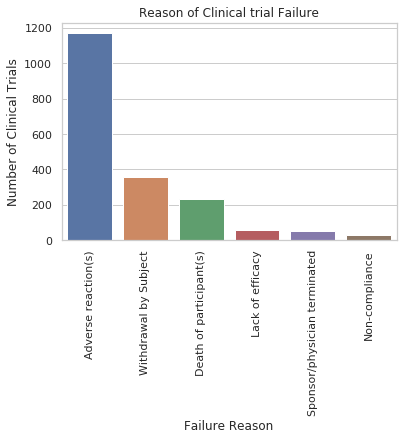

In [54]:

import seaborn as sns
sns.set(style="whitegrid", color_codes=True)
ax1 = sns.countplot(x="reason",data=df, order = df['reason'].value_counts().index)
ax1.set_title("Reason of Clinical trial Failure")
plt.ylabel("Number of Clinical Trials")
plt.xlabel("Failure Reason")
for item in ax1.get_xticklabels():
    item.set_rotation(90)
    
plt.savefig('2016+_failure_reason.png', dpi=300, bbox_inches='tight')

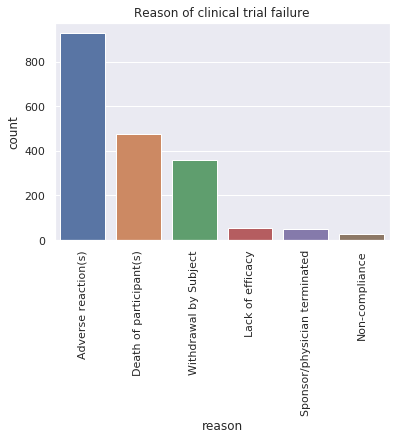

In [48]:
import seaborn as sns
sns.set(style="darkgrid")
ax1 = sns.countplot(x="reason", data=df, order = df['reason'].value_counts().index)
ax1.set_title("Reason of clinical trial failure")
for item in ax1.get_xticklabels():
    item.set_rotation(90)

In [37]:
adverse_df = pd.read_csv("filtered_clinical_trials_adverse_events_only.csv")
display(adverse_df)

,Nct_id,Phase,Condition,Summary,Title,Model,Date,reason
0,NCT03118765,Phase 2,Mild to Moderate Chronic Obstructive Pulmonary...,Pharmacodynamic and Pharmacokinetic Dose Rang...,Pharmacodynamic and Pharmacokinetic Dose Rangi...,Parallel Assignment,24-Mar-17,"NOT COMPLETED BECAUSE OF, Withdrawal by Subjec..."
1,NCT03114657,Phase 3,Alzheimer's Disease,"This randomized, double-blind, placebo-contro...",A Study of Crenezumab Versus Placebo to Evalua...,Parallel Assignment,29-Mar-17,"NOT COMPLETED BECAUSE OF, Adverse Event, Death..."
2,NCT03110380,Phase 3,HIV-1-infection,The primary objective of this study is to eva...,Switching to a Fixed Dose Combination of Bicte...,Parallel Assignment,12-Jun-17,"NOT COMPLETED BECAUSE OF, Randomized and Never..."
3,NCT03115112,Phase 3,Type 2 Diabetes Mellitus,The purpose of this study is to investigate t...,Safety and Efficacy of Bexagliflozin Compared ...,Parallel Assignment,12-Oct-17,"NOT COMPLETED BECAUSE OF, Adverse Event, Withd..."
4,NCT03119701,Phase 2,Multi Organ Failure,A study to assess effectiveness and safety of...,Efficacy and Safety of FP-1201-lyo (Interferon...,Parallel Assignment,18-Feb-17,"NOT COMPLETED BECAUSE OF, Death, Adverse Event..."
5,NCT03181503,Phase 2,Prurigo Nodularis,The aim of this study is to assess the safety...,Safety and Efficacy of Nemolizumab in PN,Parallel Assignment,2-Oct-17,"NOT COMPLETED BECAUSE OF, Adverse Event, Proto..."
6,NCT03180801,Phase 2,Influenza,FLU-v is a broad spectrum influenza vaccine t...,Efficacy of FLU-v in an H1N1 Influenza Human C...,Parallel Assignment,18-Aug-16,"NOT COMPLETED BECAUSE OF, Physician Decision, ..."
7,NCT03180528,Phase 2,Skin Basal Cell Carcinoma,This phase 2 trial studies how well remetinos...,Topical Remetinostat in Treating Patient With ...,Single Group Assignment,7-Jul-18,"NOT COMPLETED BECAUSE OF, Adverse Event, Withd..."
8,NCT03187301,Phase 2,Off Episodes of Parkinson Disease,A cardiac safety study of an investigational ...,A Cardiac Safety Study of an Investigational D...,Crossover Assignment,3-Aug-17,"NOT COMPLETED BECAUSE OF, Adverse Event, Withd..."
9,NCT03185481,Phase 2,Parkinson's Disease With Motor Fluctuations,The purpose of this study is to evaluate the ...,Safety and Tolerability of PF-06649751 in Park...,Parallel Assignment,6-Jul-17,"NOT COMPLETED BECAUSE OF, Adverse Event, Study..."


In [52]:
adverse_df.loc[adverse_df.Condition.str.contains('cancer'), 'Condition'] = 'Cancer'
adverse_df.loc[adverse_df.Condition.str.contains('Cancer'), 'Condition'] = 'Cancer'

adverse_df.loc[adverse_df.Condition.str.contains(r'adeno(?!$)'), 'Condition'] = 'Cancer'
adverse_df.loc[adverse_df.Condition.str.contains(r'adeno(?!$)'), 'Condition'] = 'Cancer'

adverse_df.loc[adverse_df.Condition.str.contains('cell'), 'Condition'] = 'Cancer'
adverse_df.loc[adverse_df.Condition.str.contains('Cell'), 'Condition'] = 'Cancer'

adverse_df.loc[adverse_df.Condition.str.contains('carc'), 'Condition'] = 'Cancer'
adverse_df.loc[adverse_df.Condition.str.contains('Carc'), 'Condition'] = 'Cancer'

adverse_df.loc[adverse_df.Condition.str.contains('tumor'), 'Condition'] = 'Cancer'
adverse_df.loc[adverse_df.Condition.str.contains('Tumor'), 'Condition'] = 'Cancer'

adverse_df.loc[adverse_df.Condition.str.contains('walden'), 'Condition'] = 'Cancer'
adverse_df.loc[adverse_df.Condition.str.contains('Walden'), 'Condition'] = 'Cancer'

adverse_df.loc[adverse_df.Condition.str.contains('fibroid'), 'Condition'] = 'Cancer'
adverse_df.loc[adverse_df.Condition.str.contains('Fibroid'), 'Condition'] = 'Cancer'

adverse_df.loc[adverse_df.Condition.str.contains('squamous'), 'Condition'] = 'Cancer'
adverse_df.loc[adverse_df.Condition.str.contains('Squamous'), 'Condition'] = 'Cancer'

adverse_df.loc[adverse_df.Condition.str.contains('prostat'), 'Condition'] = 'Cancer'
adverse_df.loc[adverse_df.Condition.str.contains('Prostat'), 'Condition'] = 'Cancer'

adverse_df.loc[adverse_df.Condition.str.contains('polyp'), 'Condition'] = 'Cancer'
adverse_df.loc[adverse_df.Condition.str.contains('Polyp'), 'Condition'] = 'Cancer'

adverse_df.loc[adverse_df.Condition.str.contains('myeloma'), 'Condition'] = 'Cancer'
adverse_df.loc[adverse_df.Condition.str.contains('Myeloma'), 'Condition'] = 'Cancer'

adverse_df.loc[adverse_df.Condition.str.contains('myoma'), 'Condition'] = 'Cancer'
adverse_df.loc[adverse_df.Condition.str.contains('Myoma'), 'Condition'] = 'Cancer'

adverse_df.loc[adverse_df.Condition.str.contains('phoma'), 'Condition'] = 'Cancer'
adverse_df.loc[adverse_df.Condition.str.contains('Phoma'), 'Condition'] = 'Cancer'

adverse_df.loc[adverse_df.Condition.str.contains('phomic'), 'Condition'] = 'Cancer'
adverse_df.loc[adverse_df.Condition.str.contains('Phomic'), 'Condition'] = 'Cancer'

################################################################################################################

adverse_df.loc[adverse_df.Condition.str.contains('hemo'), 'Condition'] = 'Blood disorder'
adverse_df.loc[adverse_df.Condition.str.contains('Hemo'), 'Condition'] = 'Blood disorder'

adverse_df.loc[adverse_df.Condition.str.contains('anem'), 'Condition'] = 'Blood disorder'
adverse_df.loc[adverse_df.Condition.str.contains('Anem'), 'Condition'] = 'Blood disorder'

adverse_df.loc[adverse_df.Condition.str.contains('willebrand'), 'Condition'] = 'Blood disorder'
adverse_df.loc[adverse_df.Condition.str.contains('Willebrand'), 'Condition'] = 'Blood disorder'

adverse_df.loc[adverse_df.Condition.str.contains('uremi'), 'Condition'] = 'Blood disorder'
adverse_df.loc[adverse_df.Condition.str.contains('Uremi'), 'Condition'] = 'Blood disorder'

adverse_df.loc[adverse_df.Condition.str.contains('thromb'), 'Condition'] = 'Blood disorder'
adverse_df.loc[adverse_df.Condition.str.contains('Thromb'), 'Condition'] = 'Blood disorder'

adverse_df.loc[adverse_df.Condition.str.contains('sickle'), 'Condition'] = 'Blood disorder'
adverse_df.loc[adverse_df.Condition.str.contains('Sickle'), 'Condition'] = 'Blood disorder'

adverse_df.loc[adverse_df.Condition.str.contains('phyria'), 'Condition'] = 'Blood disorder'
adverse_df.loc[adverse_df.Condition.str.contains('Phyria'), 'Condition'] = 'Blood disorder'

adverse_df.loc[adverse_df.Condition.str.contains('cythemia'), 'Condition'] = 'Blood disorder'
adverse_df.loc[adverse_df.Condition.str.contains('Cythemia'), 'Condition'] = 'Blood disorder'

adverse_df.loc[adverse_df.Condition.str.contains('clott'), 'Condition'] = 'Blood disorder'
adverse_df.loc[adverse_df.Condition.str.contains('Clott'), 'Condition'] = 'Blood disorder'

##################################################################################################################


adverse_df.loc[adverse_df.Condition.str.contains('diabet'), 'Condition'] = 'Diabetes'
adverse_df.loc[adverse_df.Condition.str.contains('Diabet'), 'Condition'] = 'Diabetes'


########################################################################################################################
adverse_df.loc[adverse_df.Condition.str.contains('enceph'), 'Condition'] = 'CNS autoimmune'
adverse_df.loc[adverse_df.Condition.str.contains('Enceph'), 'Condition'] = 'CNS autoimmune'

adverse_df.loc[adverse_df.Condition.str.contains('dementia'), 'Condition'] = 'CNS autoimmune'
adverse_df.loc[adverse_df.Condition.str.contains('Dementia'), 'Condition'] = 'CNS autoimmune'

adverse_df.loc[adverse_df.Condition.str.contains('neuro'), 'Condition'] = 'CNS autoimmune'
adverse_df.loc[adverse_df.Condition.str.contains('Neuro'), 'Condition'] = 'CNS autoimmune'

adverse_df.loc[adverse_df.Condition.str.contains('schiz'), 'Condition'] = 'CNS autoimmune'
adverse_df.loc[adverse_df.Condition.str.contains('Schiz'), 'Condition'] = 'CNS autoimmune'

adverse_df.loc[adverse_df.Condition.str.contains('MS'), 'Condition'] = 'CNS autoimmune'
adverse_df.loc[adverse_df.Condition.str.contains('PSP'), 'Condition'] = 'CNS autoimmune'

adverse_df.loc[adverse_df.Condition.str.contains('parkinson'), 'Condition'] = 'CNS autoimmune'
adverse_df.loc[adverse_df.Condition.str.contains('Parkinson'), 'Condition'] = 'CNS autoimmune'

adverse_df.loc[adverse_df.Condition.str.contains('spondy'), 'Condition'] = 'CNS autoimmune'
adverse_df.loc[adverse_df.Condition.str.contains('Spondy'), 'Condition'] = 'CNS autoimmune'

adverse_df.loc[adverse_df.Condition.str.contains('scleros'), 'Condition'] = 'CNS autoimmune'
adverse_df.loc[adverse_df.Condition.str.contains('Scleros'), 'Condition'] = 'CNS autoimmune'

#######################################################################################################################

adverse_df.loc[adverse_df.Condition.str.contains('Cereb'), 'Condition'] = 'CNS disorder'
adverse_df.loc[adverse_df.Condition.str.contains('cereb'), 'Condition'] = 'CNS disorder'

adverse_df.loc[adverse_df.Condition.str.contains('alzh'), 'Condition'] = 'CNS disorder'
adverse_df.loc[adverse_df.Condition.str.contains('Alzh'), 'Condition'] = 'CNS disorder'

adverse_df.loc[adverse_df.Condition.str.contains('epilep'), 'Condition'] = 'CNS disorder'
adverse_df.loc[adverse_df.Condition.str.contains('Epilep'), 'Condition'] = 'CNS disorder'

adverse_df.loc[adverse_df.Condition.str.contains('migraine'), 'Condition'] = 'CNS disorder'
adverse_df.loc[adverse_df.Condition.str.contains('Migraine'), 'Condition'] = 'CNS disorder'

adverse_df.loc[adverse_df.Condition.str.contains('spin'), 'Condition'] = 'CNS disorder'
adverse_df.loc[adverse_df.Condition.str.contains('Spin'), 'Condition'] = 'CNS disorder'

adverse_df.loc[adverse_df.Condition.str.contains('seizure'), 'Condition'] = 'CNS disorder'
adverse_df.loc[adverse_df.Condition.str.contains('Seizure'), 'Condition'] = 'CNS disorder'

adverse_df.loc[adverse_df.Condition.str.contains('stroke'), 'Condition'] = 'CNS disorder'
adverse_df.loc[adverse_df.Condition.str.contains('Stroke'), 'Condition'] = 'CNS disorder'

adverse_df.loc[adverse_df.Condition.str.contains('spastic'), 'Condition'] = 'CNS disorder'
adverse_df.loc[adverse_df.Condition.str.contains('Spastic'), 'Condition'] = 'CNS disorder'

adverse_df.loc[adverse_df.Condition.str.contains('seizure'), 'Condition'] = 'CNS disorder'
adverse_df.loc[adverse_df.Condition.str.contains('Seizure'), 'Condition'] = 'CNS disorder'

########################################################################################################################

adverse_df.loc[adverse_df.Condition.str.contains('amyloid'), 'Condition'] = 'Inflammation/Autoimmune (others)'
adverse_df.loc[adverse_df.Condition.str.contains('amyloid'), 'Condition'] = 'Inflammation/Autoimmune (others)'

adverse_df.loc[adverse_df.Condition.str.contains('SLE'), 'Condition'] = 'Inflammation/Autoimmune (others)'
adverse_df.loc[adverse_df.Condition.str.contains('Sle'), 'Condition'] = 'Inflammation/Autoimmune (others)'

adverse_df.loc[adverse_df.Condition.str.contains('sjogren'), 'Condition'] = 'Inflammation/Autoimmune (others)'
adverse_df.loc[adverse_df.Condition.str.contains('Sjogren'), 'Condition'] = 'Inflammation/Autoimmune (others)'

adverse_df.loc[adverse_df.Condition.str.contains('Sjgren'), 'Condition'] = 'Inflammation/Autoimmune (others)'
adverse_df.loc[adverse_df.Condition.str.contains('sjgren'), 'Condition'] = 'Inflammation/Autoimmune (others)'

adverse_df.loc[adverse_df.Condition.str.contains('rhin'), 'Condition'] = 'Inflammation/Autoimmune (others)'
adverse_df.loc[adverse_df.Condition.str.contains('Rhin'), 'Condition'] = 'Inflammation/Autoimmune (others)'

##########################################################################################################################

adverse_df.loc[adverse_df.Condition.str.contains('cardio'), 'Condition'] = 'Heart (circulation) condition'
adverse_df.loc[adverse_df.Condition.str.contains('Cardio'), 'Condition'] = 'Heart (circulation) condition'

adverse_df.loc[adverse_df.Condition.str.contains('artery'), 'Condition'] = 'Heart (circulation) condition'
adverse_df.loc[adverse_df.Condition.str.contains('Artery'), 'Condition'] = 'Heart (circulation) condition'

adverse_df.loc[adverse_df.Condition.str.contains('vascular'), 'Condition'] = 'Heart (circulation) condition'
adverse_df.loc[adverse_df.Condition.str.contains('Vascular'), 'Condition'] = 'Heart (circulation) condition'

adverse_df.loc[adverse_df.Condition.str.contains('ventric'), 'Condition'] = 'Heart (circulation) condition'
adverse_df.loc[adverse_df.Condition.str.contains('Ventric'), 'Condition'] = 'Heart (circulation) condition'

adverse_df.loc[adverse_df.Condition.str.contains('septa'), 'Condition'] = 'Heart (circulation) condition'
adverse_df.loc[adverse_df.Condition.str.contains('Septa'), 'Condition'] = 'Heart (circulation) condition'

adverse_df.loc[adverse_df.Condition.str.contains('aort'), 'Condition'] = 'Heart (circulation) condition'
adverse_df.loc[adverse_df.Condition.str.contains('Aort'), 'Condition'] = 'Heart (circulation) condition'

adverse_df.loc[adverse_df.Condition.str.contains('vein'), 'Condition'] = 'Heart (circulation) condition'
adverse_df.loc[adverse_df.Condition.str.contains('Vein'), 'Condition'] = 'Heart (circulation) condition'

adverse_df.loc[adverse_df.Condition.str.contains('statin'), 'Condition'] = 'Heart (circulation) condition'
adverse_df.loc[adverse_df.Condition.str.contains('Statin'), 'Condition'] = 'Heart (circulation) condition'

adverse_df.loc[adverse_df.Condition.str.contains('cardi'), 'Condition'] = 'Heart (circulation) condition'
adverse_df.loc[adverse_df.Condition.str.contains('Cardi'), 'Condition'] = 'Heart (circulation) condition'

adverse_df.loc[adverse_df.Condition.str.contains('pannicul'), 'Condition'] = 'Heart (circulation) condition'
adverse_df.loc[adverse_df.Condition.str.contains('Pannicul'), 'Condition'] = 'Heart (circulation) condition'

#########################################################################################################################

adverse_df.loc[adverse_df.Condition.str.contains('bacter'), 'Condition'] = 'Antibiotics'
adverse_df.loc[adverse_df.Condition.str.contains('Bacter'), 'Condition'] = 'Antibioitcs'

adverse_df.loc[adverse_df.Condition.str.contains('sonnei'), 'Condition'] = 'Antibiotics'
adverse_df.loc[adverse_df.Condition.str.contains('Sonnei'), 'Condition'] = 'Antibioitcs'

adverse_df.loc[adverse_df.Condition.str.contains('antibiot',regex=False), 'Condition'] = 'Antibiotics'
adverse_df.loc[adverse_df.Condition.str.contains('Antibiot',regex=False), 'Condition'] = 'Antibioitcs'

adverse_df.loc[adverse_df.Condition.str.contains('shigella'), 'Condition'] = 'Antibiotics'
adverse_df.loc[adverse_df.Condition.str.contains('Shigella'), 'Condition'] = 'Antibioitcs'

adverse_df.loc[adverse_df.Condition.str.contains('coccal'), 'Condition'] = 'Antibiotics'
adverse_df.loc[adverse_df.Condition.str.contains('Coccal'), 'Condition'] = 'Antibioitcs'

adverse_df.loc[adverse_df.Condition.str.contains('candid'), 'Condition'] = 'Antibiotics'
adverse_df.loc[adverse_df.Condition.str.contains('Candid'), 'Condition'] = 'Antibioitcs'

adverse_df.loc[adverse_df.Condition.str.contains('peridon'), 'Condition'] = 'Antibiotics'
adverse_df.loc[adverse_df.Condition.str.contains('Peridon'), 'Condition'] = 'Antibioitcs'

#########################################################################################################################

adverse_df.loc[adverse_df.Condition.str.contains('alopecia'), 'Condition'] = 'Hair/Cosmetics/Aging/Stress'
adverse_df.loc[adverse_df.Condition.str.contains('Alopecia'), 'Condition'] = 'Hair/Cosmetics/Aging/Stress'

adverse_df.loc[adverse_df.Condition.str.contains('aging'), 'Condition'] = 'Hair/Cosmetics/Aging/Stress'
adverse_df.loc[adverse_df.Condition.str.contains('Aging'), 'Condition'] = 'Hair/Cosmetics/Aging/Stress'

adverse_df.loc[adverse_df.Condition.str.contains('age'), 'Condition'] = 'Hair/Cosmetics/Aging/Stress'
adverse_df.loc[adverse_df.Condition.str.contains('Age'), 'Condition'] = 'Hair/Cosmetics/Aging/Stress'

adverse_df.loc[adverse_df.Condition.str.contains('wart'), 'Condition'] = 'Hair/Cosmetics/Aging/Stress'
adverse_df.loc[adverse_df.Condition.str.contains('Wart'), 'Condition'] = 'Hair/Cosmetics/Aging/Stress'

adverse_df.loc[adverse_df.Condition.str.contains('vitiligo'), 'Condition'] = 'Hair/Cosmetics/Aging/Stress'
adverse_df.loc[adverse_df.Condition.str.contains('Vitiligo'), 'Condition'] = 'Hair/Cosmetics/Aging/Stress'

adverse_df.loc[adverse_df.Condition.str.contains('pigment'), 'Condition'] = 'Hair/Cosmetics/Aging/Stress'
adverse_df.loc[adverse_df.Condition.str.contains('Pigment'), 'Condition'] = 'Hair/Cosmetics/Aging/Stress'

adverse_df.loc[adverse_df.Condition.str.contains('stress'), 'Condition'] = 'Hair/Cosmetics/Aging/Stress'
adverse_df.loc[adverse_df.Condition.str.contains('Stress'), 'Condition'] = 'Hair/Cosmetics/Aging/Stress'

adverse_df.loc[adverse_df.Condition.str.contains('sleep'), 'Condition'] = 'Hair/Cosmetics/Aging/Stress'
adverse_df.loc[adverse_df.Condition.str.contains('Sleep'), 'Condition'] = 'Hair/Cosmetics/Aging/Stress'

adverse_df.loc[adverse_df.Condition.str.contains('traumatic'), 'Condition'] = 'Hair/Cosmetics/Aging/Stress'
adverse_df.loc[adverse_df.Condition.str.contains('Traumatic'), 'Condition'] = 'Hair/Cosmetics/Aging/Stress'

adverse_df.loc[adverse_df.Condition.str.contains('activity'), 'Condition'] = 'Hair/Cosmetics/Aging/Stress'
adverse_df.loc[adverse_df.Condition.str.contains('Activity'), 'Condition'] = 'Hair/Cosmetics/Aging/Stress'

adverse_df.loc[adverse_df.Condition.str.contains('active'), 'Condition'] = 'Hair/Cosmetics/Aging/Stress'
adverse_df.loc[adverse_df.Condition.str.contains('Active'), 'Condition'] = 'Hair/Cosmetics/Aging/Stress'


##########################################################################################################################

adverse_df.loc[adverse_df.Condition.str.contains('ART'), 'Condition'] = 'Reproduction'

adverse_df.loc[adverse_df.Condition.str.contains('partum'), 'Condition'] = 'Reproduction'
adverse_df.loc[adverse_df.Condition.str.contains('Partum'), 'Condition'] = 'Reproduction'

adverse_df.loc[adverse_df.Condition.str.contains('ovar'), 'Condition'] = 'Reproduction'
adverse_df.loc[adverse_df.Condition.str.contains('Ovar'), 'Condition'] = 'Reproduction'

adverse_df.loc[adverse_df.Condition.str.contains('natal'), 'Condition'] = 'Reproduction'
adverse_df.loc[adverse_df.Condition.str.contains('Natal'), 'Condition'] = 'Reproduction'

adverse_df.loc[adverse_df.Condition.str.contains('fertil'), 'Condition'] = 'Reproduction'
adverse_df.loc[adverse_df.Condition.str.contains('Fertil'), 'Condition'] = 'Reproduction'


######################################################################################################################

adverse_df.loc[adverse_df.Condition.str.contains('vira'), 'Condition'] = 'Antiviral'
adverse_df.loc[adverse_df.Condition.str.contains('Vira'), 'Condition'] = 'Antiviral'

adverse_df.loc[adverse_df.Condition.str.contains('SARS'), 'Condition'] = 'Antiviral'
adverse_df.loc[adverse_df.Condition.str.contains('Sars'), 'Condition'] = 'Antiviral'

adverse_df.loc[adverse_df.Condition.str.contains('cov'), 'Condition'] = 'Antiviral'
adverse_df.loc[adverse_df.Condition.str.contains('Cov'), 'Condition'] = 'Antiviral'

adverse_df.loc[adverse_df.Condition.str.contains('COV'), 'Condition'] = 'Antiviral'
adverse_df.loc[adverse_df.Condition.str.contains('CoV'), 'Condition'] = 'Antiviral'

adverse_df.loc[adverse_df.Condition.str.contains('pox'), 'Condition'] = 'Antiviral'
adverse_df.loc[adverse_df.Condition.str.contains('Pox'), 'Condition'] = 'Antiviral'

adverse_df.loc[adverse_df.Condition.str.contains('simplex'), 'Condition'] = 'Antiviral'
adverse_df.loc[adverse_df.Condition.str.contains('Simplex'), 'Condition'] = 'Antiviral'

adverse_df.loc[adverse_df.Condition.str.contains('rabi'), 'Condition'] = 'Antiviral'
adverse_df.loc[adverse_df.Condition.str.contains('Rabi'), 'Condition'] = 'Antiviral'

adverse_df.loc[adverse_df.Condition.str.contains('herp'), 'Condition'] = 'Antiviral'
adverse_df.loc[adverse_df.Condition.str.contains('Herp'), 'Condition'] = 'Antiviral'

adverse_df.loc[adverse_df.Condition.str.contains('influenza'), 'Condition'] = 'Antiviral'
adverse_df.loc[adverse_df.Condition.str.contains('Influenza'), 'Condition'] = 'Antiviral'

#####################################################################################################################

adverse_df.loc[adverse_df.Condition.str.contains('ulcer'), 'Condition'] = 'Digestive'
adverse_df.loc[adverse_df.Condition.str.contains('Ulcer'), 'Condition'] = 'Digestive'

adverse_df.loc[adverse_df.Condition.str.contains('intestin'), 'Condition'] = 'Digestive'
adverse_df.loc[adverse_df.Condition.str.contains('Intestin'), 'Condition'] = 'Digestive'

adverse_df.loc[adverse_df.Condition.str.contains('digest'), 'Condition'] = 'Digestive'
adverse_df.loc[adverse_df.Condition.str.contains('Digest'), 'Condition'] = 'Digestive'

#####################################################################################################################

adverse_df.loc[adverse_df.Condition.str.contains('bone'), 'Condition'] = 'Bones/Joints Inflammation'
adverse_df.loc[adverse_df.Condition.str.contains('Bone'), 'Condition'] = 'Bones/Joints Inflammation'

adverse_df.loc[adverse_df.Condition.str.contains('rheum'), 'Condition'] = 'Bones/Joints Inflammation'
adverse_df.loc[adverse_df.Condition.str.contains('Rheum'), 'Condition'] = 'Bones/Joints Inflammation'

adverse_df.loc[adverse_df.Condition.str.contains('joint'), 'Condition'] = 'Bones/Joints Inflammation'
adverse_df.loc[adverse_df.Condition.str.contains('Joint'), 'Condition'] = 'Bones/Joints Inflammation'

########################################################################################################################

adverse_df.loc[adverse_df.Condition.str.contains('retin'), 'Condition'] = 'Eye Disorder'
adverse_df.loc[adverse_df.Condition.str.contains('Retin'), 'Condition'] = 'Eye Disorder'

adverse_df.loc[adverse_df.Condition.str.contains('eye'), 'Condition'] = 'Eye Disorder'
adverse_df.loc[adverse_df.Condition.str.contains('Eye'), 'Condition'] = 'Eye Disorder'

adverse_df.loc[adverse_df.Condition.str.contains('Opia'), 'Condition'] = 'Eye Disorder'
adverse_df.loc[adverse_df.Condition.str.contains('opia'), 'Condition'] = 'Eye Disorder'

adverse_df.loc[adverse_df.Condition.str.contains('Opic'), 'Condition'] = 'Eye Disorder'
adverse_df.loc[adverse_df.Condition.str.contains('opic'), 'Condition'] = 'Eye Disorder'

adverse_df.loc[adverse_df.Condition.str.contains('pupil'), 'Condition'] = 'Eye Disorder'
adverse_df.loc[adverse_df.Condition.str.contains('Pupil'), 'Condition'] = 'Eye Disorder'

########################################################################################################################

adverse_df.loc[adverse_df.Condition.str.contains('respir'), 'Condition'] = 'Respiratory'
adverse_df.loc[adverse_df.Condition.str.contains('Respir'), 'Condition'] = 'Respiratory'

adverse_df.loc[adverse_df.Condition.str.contains('pulmon'), 'Condition'] = 'Respiratory'
adverse_df.loc[adverse_df.Condition.str.contains('Pulmon'), 'Condition'] = 'Respiratory'

adverse_df.loc[adverse_df.Condition.str.contains('pneumon'), 'Condition'] = 'Respiratory'
adverse_df.loc[adverse_df.Condition.str.contains('Pneumon'), 'Condition'] = 'Respiratory'

adverse_df.loc[adverse_df.Condition.str.contains('obstructive'), 'Condition'] = 'Respiratory'
adverse_df.loc[adverse_df.Condition.str.contains('Obstructive'), 'Condition'] = 'Respiratory'

adverse_df.loc[adverse_df.Condition.str.contains('COPD'), 'Condition'] = 'Respiratory'
adverse_df.loc[adverse_df.Condition.str.contains('copd'), 'Condition'] = 'Respiratory'

adverse_df.loc[adverse_df.Condition.str.contains('Fibrosis'), 'Condition'] = 'Respiratory'
adverse_df.loc[adverse_df.Condition.str.contains('fibrosis'), 'Condition'] = 'Respiratory'

########################################################################################################################

adverse_df.loc[adverse_df.Condition.str.contains('urin'), 'Condition'] = 'Urinary'
adverse_df.loc[adverse_df.Condition.str.contains('Urin'), 'Condition'] = 'Urinary'

adverse_df.loc[adverse_df.Condition.str.contains('Rena'), 'Condition'] = 'Urinary'
adverse_df.loc[adverse_df.Condition.str.contains('rena'), 'Condition'] = 'Urinary'

adverse_df.loc[adverse_df.Condition.str.contains('neph'), 'Condition'] = 'Urinary'
adverse_df.loc[adverse_df.Condition.str.contains('Neph'), 'Condition'] = 'Urinary'

########################################################################################################################

adverse_df.loc[adverse_df.Condition.str.contains('Urticaria'), 'Condition'] = 'Skin Infection/Allergy'
adverse_df.loc[adverse_df.Condition.str.contains('urticaria'), 'Condition'] = 'Skin Infection/Allergy'

adverse_df.loc[adverse_df.Condition.str.contains('histamin'), 'Condition'] = 'Skin Infection/Allergy'
adverse_df.loc[adverse_df.Condition.str.contains('Histamin'), 'Condition'] = 'Skin Infection/Allergy'

adverse_df.loc[adverse_df.Condition.str.contains('allerg'), 'Condition'] = 'Skin Infection/Allergy'
adverse_df.loc[adverse_df.Condition.str.contains('Allerg'), 'Condition'] = 'Skin Infection/Allergy'

adverse_df.loc[adverse_df.Condition.str.contains('telangiect'), 'Condition'] = 'Skin Infection/Allergy'
adverse_df.loc[adverse_df.Condition.str.contains('Telangiect'), 'Condition'] = 'Skin Infection/Allergy'

adverse_df.loc[adverse_df.Condition.str.contains('sclerod'), 'Condition'] = 'Skin Infection/Allergy'
adverse_df.loc[adverse_df.Condition.str.contains('Sclerod'), 'Condition'] = 'Skin Infection/Allergy'

adverse_df.loc[adverse_df.Condition.str.contains('derm'), 'Condition'] = 'Skin Infection/Allergy'
adverse_df.loc[adverse_df.Condition.str.contains('Derm'), 'Condition'] = 'Skin Infection/Allergy'

adverse_df.loc[adverse_df.Condition.str.contains('seborrheic'), 'Condition'] = 'Skin Infection/Allergy'
adverse_df.loc[adverse_df.Condition.str.contains('Seborrheic'), 'Condition'] = 'Skin Infection/Allergy'

adverse_df.loc[adverse_df.Condition.str.contains('rosacea'), 'Condition'] = 'Skin Infection/Allergy'
adverse_df.loc[adverse_df.Condition.str.contains('Rosacea'), 'Condition'] = 'Skin Infection/Allergy'

adverse_df.loc[adverse_df.Condition.str.contains('psori'), 'Condition'] = 'Skin Infection/Allergy'
adverse_df.loc[adverse_df.Condition.str.contains('Psori'), 'Condition'] = 'Skin Infection/Allergy'

adverse_df.loc[adverse_df.Condition.str.contains('prurigo'), 'Condition'] = 'Skin Infection/Allergy'
adverse_df.loc[adverse_df.Condition.str.contains('Prurigo'), 'Condition'] = 'Skin Infection/Allergy'

####################################################################################################################

adverse_df.loc[adverse_df.Condition.str.contains('vaccine'), 'Condition'] = 'Vaccine'
adverse_df.loc[adverse_df.Condition.str.contains('Vaccine'), 'Condition'] = 'Vaccine'

adverse_df.loc[adverse_df.Condition.str.contains('adjuvant'), 'Condition'] = 'Vaccine'
adverse_df.loc[adverse_df.Condition.str.contains('Adjuvant'), 'Condition'] = 'Vaccine'

####################################################################################################################

adverse_df.loc[adverse_df.Condition.str.contains('transplant'), 'Condition'] = 'Hospital Care'
adverse_df.loc[adverse_df.Condition.str.contains('Transplant'), 'Condition'] = 'Hospital Care'

adverse_df.loc[adverse_df.Condition.str.contains('transfus'), 'Condition'] = 'Hospital Care'
adverse_df.loc[adverse_df.Condition.str.contains('Transfus'), 'Condition'] = 'Hospital Care'

adverse_df.loc[adverse_df.Condition.str.contains('sedat'), 'Condition'] = 'Hospital Care'
adverse_df.loc[adverse_df.Condition.str.contains('Sedat'), 'Condition'] = 'Hospital Care'

adverse_df.loc[adverse_df.Condition.str.contains('Pediatric'), 'Condition'] = 'Hospital Care'
adverse_df.loc[adverse_df.Condition.str.contains('pediatric'), 'Condition'] = 'Hospital Care'

####################################################################################################################

adverse_df.loc[adverse_df.Condition.str.contains('clonic'), 'Condition'] = 'Muscle Disorder CNS/Others'
adverse_df.loc[adverse_df.Condition.str.contains('Clonic'), 'Condition'] = 'Muscle Disorder CNS/Others'

adverse_df.loc[adverse_df.Condition.str.contains('tend'), 'Condition'] = 'Muscle Disorder CNS/Others'
adverse_df.loc[adverse_df.Condition.str.contains('Tend'), 'Condition'] = 'Muscle Disorder CNS/Others'

adverse_df.loc[adverse_df.Condition.str.contains('Sarco'), 'Condition'] = 'Muscle Disorder CNS/Others'
adverse_df.loc[adverse_df.Condition.str.contains('sarco'), 'Condition'] = 'Muscle Disorder CNS/Others'

adverse_df.loc[adverse_df.Condition.str.contains('CEPS'), 'Condition'] = 'Muscle Disorder CNS/Others'

adverse_df.loc[adverse_df.Condition.str.contains('motor'), 'Condition'] = 'Muscle Disorder CNS/Others'
adverse_df.loc[adverse_df.Condition.str.contains('Motor'), 'Condition'] = 'Muscle Disorder CNS/Others'

####################################################################################################################

adverse_df.loc[adverse_df.Condition.str.contains('cohol'), 'Condition'] = 'Alcohol/Liver'
adverse_df.loc[adverse_df.Condition.str.contains('Cohol'), 'Condition'] = 'Alcohol/Liver'

adverse_df.loc[adverse_df.Condition.str.contains('steat'), 'Condition'] = 'Alcohol/Liver'
adverse_df.loc[adverse_df.Condition.str.contains('Steat'), 'Condition'] = 'Alcohol/Liver'

adverse_df.loc[adverse_df.Condition.str.contains('Pancreati'), 'Condition'] = 'Alcohol/Liver'
adverse_df.loc[adverse_df.Condition.str.contains('pancreati'), 'Condition'] = 'Alcohol/Liver'

####################################################################################################################

adverse_df.loc[adverse_df.Condition.str.contains('tremor'), 'Condition'] = 'Others'
adverse_df.loc[adverse_df.Condition.str.contains('Tremor'), 'Condition'] = 'Others'

adverse_df.loc[adverse_df.Condition.str.contains('Sequalae'), 'Condition'] = 'Others'
adverse_df.loc[adverse_df.Condition.str.contains('sequalae'), 'Condition'] = 'Others'

adverse_df.loc[adverse_df.Condition.str.contains('Opioid'), 'Condition'] = 'Others'
adverse_df.loc[adverse_df.Condition.str.contains('opioid'), 'Condition'] = 'Others'

In [59]:
display(adverse_df)

adverse_df.to_csv('adverse_df_classified.csv',index=False, encoding='utf-8', quoting=csv.QUOTE_NONNUMERIC)

,Nct_id,Phase,Condition,Summary,Title,Model,Date,reason
0,NCT03118765,Phase 2,Respiratory,Pharmacodynamic and Pharmacokinetic Dose Rang...,Pharmacodynamic and Pharmacokinetic Dose Rangi...,Parallel Assignment,24-Mar-17,"NOT COMPLETED BECAUSE OF, Withdrawal by Subjec..."
1,NCT03114657,Phase 3,CNS disorder,"This randomized, double-blind, placebo-contro...",A Study of Crenezumab Versus Placebo to Evalua...,Parallel Assignment,29-Mar-17,"NOT COMPLETED BECAUSE OF, Adverse Event, Death..."
2,NCT03110380,Phase 3,HIV-1-infection,The primary objective of this study is to eva...,Switching to a Fixed Dose Combination of Bicte...,Parallel Assignment,12-Jun-17,"NOT COMPLETED BECAUSE OF, Randomized and Never..."
3,NCT03115112,Phase 3,Diabetes,The purpose of this study is to investigate t...,Safety and Efficacy of Bexagliflozin Compared ...,Parallel Assignment,12-Oct-17,"NOT COMPLETED BECAUSE OF, Adverse Event, Withd..."
4,NCT03119701,Phase 2,Multi Organ Failure,A study to assess effectiveness and safety of...,Efficacy and Safety of FP-1201-lyo (Interferon...,Parallel Assignment,18-Feb-17,"NOT COMPLETED BECAUSE OF, Death, Adverse Event..."
5,NCT03181503,Phase 2,Skin Infection/Allergy,The aim of this study is to assess the safety...,Safety and Efficacy of Nemolizumab in PN,Parallel Assignment,2-Oct-17,"NOT COMPLETED BECAUSE OF, Adverse Event, Proto..."
6,NCT03180801,Phase 2,Antiviral,FLU-v is a broad spectrum influenza vaccine t...,Efficacy of FLU-v in an H1N1 Influenza Human C...,Parallel Assignment,18-Aug-16,"NOT COMPLETED BECAUSE OF, Physician Decision, ..."
7,NCT03180528,Phase 2,Cancer,This phase 2 trial studies how well remetinos...,Topical Remetinostat in Treating Patient With ...,Single Group Assignment,7-Jul-18,"NOT COMPLETED BECAUSE OF, Adverse Event, Withd..."
8,NCT03187301,Phase 2,CNS autoimmune,A cardiac safety study of an investigational ...,A Cardiac Safety Study of an Investigational D...,Crossover Assignment,3-Aug-17,"NOT COMPLETED BECAUSE OF, Adverse Event, Withd..."
9,NCT03185481,Phase 2,CNS autoimmune,The purpose of this study is to evaluate the ...,Safety and Tolerability of PF-06649751 in Park...,Parallel Assignment,6-Jul-17,"NOT COMPLETED BECAUSE OF, Adverse Event, Study..."


In [55]:
adverse_df_classified = pd.read_csv("adverse_df_classified_manual.csv")
display(adverse_df_classified)

,Nct_id,Phase,Condition,Summary,Title,Model,Date,reason
0,NCT03118765,Phase 2,Respiratory,Pharmacodynamic and Pharmacokinetic Dose Rang...,Pharmacodynamic and Pharmacokinetic Dose Rangi...,Parallel Assignment,24-Mar-17,"NOT COMPLETED BECAUSE OF, Withdrawal by Subjec..."
1,NCT03114657,Phase 3,CNS disorder,"This randomized, double-blind, placebo-contro...",A Study of Crenezumab Versus Placebo to Evalua...,Parallel Assignment,29-Mar-17,"NOT COMPLETED BECAUSE OF, Adverse Event, Death..."
2,NCT03110380,Phase 3,Antiviral,The primary objective of this study is to eva...,Switching to a Fixed Dose Combination of Bicte...,Parallel Assignment,12-Jun-17,"NOT COMPLETED BECAUSE OF, Randomized and Never..."
3,NCT03115112,Phase 3,Diabetes,The purpose of this study is to investigate t...,Safety and Efficacy of Bexagliflozin Compared ...,Parallel Assignment,12-Oct-17,"NOT COMPLETED BECAUSE OF, Adverse Event, Withd..."
4,NCT03119701,Phase 2,Hospital Care,A study to assess effectiveness and safety of...,Efficacy and Safety of FP-1201-lyo (Interferon...,Parallel Assignment,18-Feb-17,"NOT COMPLETED BECAUSE OF, Death, Adverse Event..."
5,NCT03181503,Phase 2,Skin Infection/Allergy,The aim of this study is to assess the safety...,Safety and Efficacy of Nemolizumab in PN,Parallel Assignment,2-Oct-17,"NOT COMPLETED BECAUSE OF, Adverse Event, Proto..."
6,NCT03180801,Phase 2,Antiviral,FLU-v is a broad spectrum influenza vaccine t...,Efficacy of FLU-v in an H1N1 Influenza Human C...,Parallel Assignment,18-Aug-16,"NOT COMPLETED BECAUSE OF, Physician Decision, ..."
7,NCT03180528,Phase 2,Cancer,This phase 2 trial studies how well remetinos...,Topical Remetinostat in Treating Patient With ...,Single Group Assignment,7-Jul-18,"NOT COMPLETED BECAUSE OF, Adverse Event, Withd..."
8,NCT03187301,Phase 2,CNS autoimmune,A cardiac safety study of an investigational ...,A Cardiac Safety Study of an Investigational D...,Crossover Assignment,3-Aug-17,"NOT COMPLETED BECAUSE OF, Adverse Event, Withd..."
9,NCT03185481,Phase 2,CNS autoimmune,The purpose of this study is to evaluate the ...,Safety and Tolerability of PF-06649751 in Park...,Parallel Assignment,6-Jul-17,"NOT COMPLETED BECAUSE OF, Adverse Event, Study..."


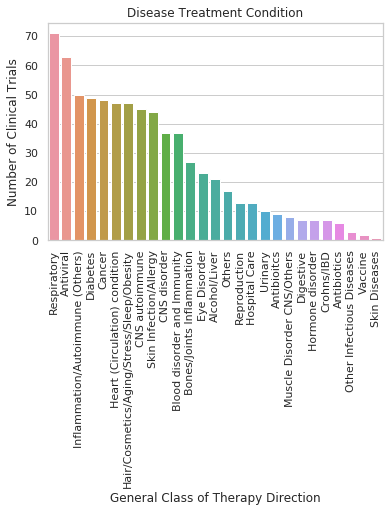

In [56]:
import seaborn as sns
sns.set(style="whitegrid")
ax1 = sns.countplot(x="Condition", data=adverse_df_classified, order = adverse_df_classified['Condition'].value_counts().index)
ax1.set_title("Disease Treatment Condition")
plt.ylabel("Number of Clinical Trials")
plt.xlabel("General Class of Therapy Direction")
for item in ax1.get_xticklabels():
    item.set_rotation(90)
    
plt.savefig('class_disease_treated.png', dpi=300,  bbox_inches='tight')

In [28]:
unique = set(adverse_df_classified['Condition'].str.replace('[^a-zA-Z ]', '').str.lower().str.split(' ').sum())

print(list(sorted(unique)))

['alcoholliver', 'and', 'antibioitcs', 'antibiotics', 'antiviral', 'autoimmune', 'blood', 'bonesjoints', 'cancer', 'care', 'circulation', 'cns', 'cnsothers', 'condition', 'crohnsibd', 'diabetes', 'digestive', 'diseases', 'disorder', 'eye', 'haircosmeticsagingstresssleepobesity', 'heart', 'hormone', 'hospital', 'immunity', 'infectionallergy', 'infectious', 'inflammation', 'inflammationautoimmune', 'muscle', 'other', 'others', 'reproduction', 'respiratory', 'skin', 'urinary', 'vaccine']


# ALL CLINIAL TRIALS

In [19]:
                        
def csv_row(xml_file):

    tree = ET.parse(xml_file)
    root = tree.getroot()
    
    nct_text = ""
    sum_text = ""
    model_text = ""
    ph_text = ""
    title_text = ""
    year_text = ""
    condition_disease_text= ""
    description_text = ""
    failed_text_full=""
    
    if root.iter('drop_withdraw_reason'):
        
        #This bit finds all roots with nct_id which is a sub_root to id_info
        for nct in root.findall('id_info'):
            nctId_text = nct.find('nct_id').text
            nct_text =nctId_text
            #print(nct_text)

        # This bit finds the brief summary text
        for s in root.findall('brief_summary'):
            summary_text = s.find('textblock').text
            sum_text= summary_text
            sum_text = sum_text.replace('\n', '') # Replaces newline with a whitespace
            sum_text = re.sub(' +',' ',sum_text) # Compresses multiple whitespaces to only one
            #print("Summary Text:", sum_text)

        # Get's the official title for the study
        for t in root.iter('brief_title'):
            title_text = t.text

        # This get's the type of intervention_model
        for y in root.iter('intervention_model'):
            model_text = y.text

        for date in root.iter('start_date'):
            year_text = date.text
            #print(year_text)

        for condition in root.iter('condition'):
            condition_disease_text = condition.text
            #print(condition_disease_text)


        for reason in root.iter('drop_withdraw_reason'):
            failed_text_full= failed_text_full+', ' +f'{reason[0].text}'
        #print("withdraw reason", failed_text_full)


    total_text = "\"" + nct_text+ "\"" + ";" + "\""+ ph_text+ "\"" + ";" + "\"" + condition_disease_text+ "\"" + ";" + "\""+ sum_text + "\"" + ";"  + "\"" + title_text + "\"" + ";"  +  "\"" + model_text + "\"" + ";" + "\""+ year_text + "\"" + ";" + "\""+ 'NOT COMPLETED BECAUSE OF' + failed_text_full+ "\""

    # This functions returns a text with Nct_Id, brief_summary, title and type of intervention model on the form we intended

    return total_text

#csv_row("/groups/cherkasvgrp/share/progressive_docking/pd_python_pose/clinical_trials/NCT0126xxxx/NCT01266460.xml")# This is for checking that the function works

In [20]:

rdir = '/groups/cherkasvgrp/share/progressive_docking/pd_python_pose/clinical_trials' # Folders in directory where the all the xml files are placed

with open('all_years_clincal_trials.csv', 'w', encoding="utf-8") as csvfile: # Opens a blank csv file
    for _, dirs, _ in os.walk(rdir):
        for dir in dirs: # Looks at  all the xml folders
            for subdir, _, files in os.walk(os.path.join(rdir,dir)):
                for file in files:
                    name = os.path.join(subdir, file)
                    try: 
                        csvfile.write(csv_row(name)) #Writes total_text into a row in to all_clinical_trials.csv
                        csvfile.write("\n") # Skips to next line and do the same
                    except:
                        print(f'your file {name} did not get parsed probably')

your file /groups/cherkasvgrp/share/progressive_docking/pd_python_pose/clinical_trials/.ipynb_checkpoints/Untitled-checkpoint.ipynb did not get parsed probably
your file /groups/cherkasvgrp/share/progressive_docking/pd_python_pose/clinical_trials/.ipynb_checkpoints/Untitled1-checkpoint.ipynb did not get parsed probably


In [21]:
# Earlier we saw that the returned text from our function was seperated by ';', so we use this as seperator when reading in the files
all_clinical_trials = pd.read_csv("all_years_clincal_trials.csv", sep=';', header=None,error_bad_lines=False, warn_bad_lines=False,
                 lineterminator='\n')

all_clinical_trials.columns =  ['Nct_id', 'Phase' , 'Condition' , 'Summary', 'Title', "Model" , 'Date' , 'Failure Reason(s)']


In [22]:
all_clinical_trials_na_removed=all_clinical_trials.dropna()
all_clinical_trials_na_removed.columns =  ['Nct_id', 'Phase' , 'Condition' , 'Summary', 'Title', "Model" , 'Date' , 'reason']
all_clinical_trials_na_removed

,Nct_id,Phase,Condition,Summary,Title,Model,Date,reason


In [26]:
all_clinical_trials.columns =  ['Nct_id', 'Phase' , 'Condition' , 'Summary', 'Title', "Model" , 'Date' , 'reason']

In [35]:
df=all_clinical_trials
len(df)

388329

In [36]:
df = df[df.reason.str.len() > 26]
len(df)

31469

In [37]:
#df['reason']=df.loc[df.reason.str.contains('Adverse')]
df=df[df['reason'].str.contains("Adverse|adverse")]

In [40]:
df.to_csv('all_years_clinical_trials_only_adverse_retained.csv', index=False, encoding='utf-8', quoting=csv.QUOTE_NONNUMERIC)

In [16]:
import pubchempy as pcp
import pandas as pd
from urllib.request import urlopen
from urllib.parse import quote
import pandas as pd

df=pd.read_csv('Drug_Smiles_api.csv')

def gt_cmpds(cmpd):
    cmpds=[]
    for compound in pcp.get_compounds(cmpd, 'name'):
        cmpds.append(compound.isomeric_smiles)
    try:
        cmpds=max((i for i in cmpds), key=len)    
        cmp=max((i for i in cmpds.split('.')), key=len)
    except:
        cmp='DID NOT WORK'
    if cmp=='DID NOT WORK':
        try:
            url = 'http://cactus.nci.nih.gov/chemical/structure/' + quote(cmpd) + '/smiles'
            cmp = urlopen(url).read().decode('utf8')
            cmp=max((i for i in cmp.split('.')), key=len)
        except:
            cmp='DID NOT WORK'
            print(cmp)
    return cmp

df['isomeric_smiles']=df['api_name'].apply(lambda x: gt_cmpds(x))

DID NOT WORK
DID NOT WORK
DID NOT WORK
DID NOT WORK
DID NOT WORK
DID NOT WORK
DID NOT WORK
DID NOT WORK
DID NOT WORK
DID NOT WORK
DID NOT WORK
DID NOT WORK
DID NOT WORK
DID NOT WORK
DID NOT WORK
DID NOT WORK
DID NOT WORK
DID NOT WORK
DID NOT WORK
DID NOT WORK
DID NOT WORK
DID NOT WORK
DID NOT WORK
DID NOT WORK
DID NOT WORK
DID NOT WORK
DID NOT WORK
DID NOT WORK
DID NOT WORK
DID NOT WORK
DID NOT WORK
DID NOT WORK
DID NOT WORK
DID NOT WORK
DID NOT WORK
DID NOT WORK
DID NOT WORK
DID NOT WORK
DID NOT WORK
DID NOT WORK
DID NOT WORK
DID NOT WORK
DID NOT WORK
DID NOT WORK
DID NOT WORK
DID NOT WORK
DID NOT WORK
DID NOT WORK
DID NOT WORK
DID NOT WORK
DID NOT WORK
DID NOT WORK
DID NOT WORK
DID NOT WORK
DID NOT WORK
DID NOT WORK
DID NOT WORK
DID NOT WORK
DID NOT WORK
DID NOT WORK
DID NOT WORK
DID NOT WORK
DID NOT WORK
DID NOT WORK
DID NOT WORK
DID NOT WORK
DID NOT WORK
DID NOT WORK
DID NOT WORK
DID NOT WORK
DID NOT WORK
DID NOT WORK
DID NOT WORK
DID NOT WORK
DID NOT WORK
DID NOT WORK
DID NOT WORK

KeyboardInterrupt: 

In [ ]:
df